In [1]:
# ===============================================================
#  Consolidado Prescriptivo 
# ===============================================================
import pandas as pd
import numpy as np

# Cargar resultados previos
multi = pd.read_csv("resultados_multi_periodo.csv")
transf = pd.read_csv("resultados_transferencias.csv")
forecast = pd.read_csv("resultados_forecast.csv")

# --- Normalizar nombres ---
if 'periodo' in multi.columns:
    multi = multi.rename(columns={'periodo': 'semana'})
if 'semana_a_futuro' in forecast.columns:
    forecast = forecast.rename(columns={'semana_a_futuro': 'semana'})

# Asegurar consistencia de tipos (int cuando sea posible)
try:
    forecast['semana'] = forecast['semana'].astype(int)
except Exception:
    forecast['semana'] = pd.to_numeric(forecast['semana'], errors='coerce').astype('Int64')

try:
    multi['semana'] = multi['semana'].astype(int)
except Exception:
    multi['semana'] = pd.to_numeric(multi['semana'], errors='coerce').astype('Int64')

# --- Ajuste para transferencias: incluir ORIGEN y DESTINO ---
# Crear tabla agregada que combine ambas tiendas (origen envía, destino recibe)
transf_origen = transf[['origen', 'cantidad_transferida', 'costo_total']].rename(
    columns={'origen': 'tienda'}
)
transf_destino = transf[['destino', 'cantidad_transferida', 'costo_total']].rename(
    columns={'destino': 'tienda'}
)

# Combinar ambas y agregar por tienda (sumar todos los costos)
transf_total = pd.concat([transf_origen, transf_destino], ignore_index=True)
transf_agregado = transf_total.groupby('tienda').agg({
    'cantidad_transferida': 'sum',
    'costo_total': 'sum'
}).reset_index().rename(columns={
    'cantidad_transferida': 'transferencia_total',
    'costo_total': 'costo_transferencia_total'
})

# --- Verificación previa ---
print('Multi:', multi.shape, '| Transf:', transf.shape, '| Forecast:', forecast.shape)
print('Columnas multi:', multi.columns.tolist())
print('Columnas forecast:', forecast.columns.tolist())
print('\n📦 Transferencias agregadas por tienda (origen + destino):')
print(transf_agregado.sort_values('costo_transferencia_total', ascending=False))

# --- Unificación segura ---
# Unimos forecast (por sku, tienda, semana) con el resultado 'multi' (pedido a nivel sku-semana)
pedido_col = 'pedido' if 'pedido' in multi.columns else None
if pedido_col is None:
    print('⚠️ No se encontró columna en multi; se mantendrá sin asignar pedido_total.')
    multi_pedido = pd.DataFrame(columns=['sku','semana','pedido_total'])
else:
    multi_pedido = multi[['sku','semana','pedido']].rename(columns={'pedido':'pedido_total'})

# --- Además: extraer stock (si existe) desde 'multi' como stock_total para poder
# --- distribuirlo por tienda o, en su defecto, crear un placeholder para evitar KeyError
stock_col = None
if 'stock' in multi.columns:
    stock_col = 'stock'
elif 'stock_total' in multi.columns:
    stock_col = 'stock_total'

if stock_col is None:
    # DataFrame vacío con columnas esperadas para el merge; evitar errores al mergear
    multi_stock = pd.DataFrame(columns=['sku', 'semana', 'stock_total'])
else:
    multi_stock = multi[['sku', 'semana', stock_col]].rename(columns={stock_col: 'stock_total'})

consolidado = forecast.merge(multi_pedido, how='left', on=['sku','semana'])
consolidado = consolidado.merge(multi_stock, how='left', on=['sku','semana'])

# Merge con transferencias agregadas (una sola vez por tienda)
consolidado = consolidado.merge(transf_agregado, how='left', on='tienda')

# --- Distribuir pedido_total por tienda usando la participación ('share') de la predicción por tienda ---
# Calculamos la suma de predicción por sku-semana y la participación por tienda
consolidado['pred_total_sku_sem'] = consolidado.groupby(['sku','semana'])['prediccion_ARIMA'].transform('sum')

# Share: cuánto representa cada tienda de la demanda total por sku-semana
# Si pred_total_sku_sem es 0, el share es 0
consolidado['share'] = np.where(
    consolidado['pred_total_sku_sem'] > 0,
    consolidado['prediccion_ARIMA'] / consolidado['pred_total_sku_sem'],
    0
)

# Distribuir pedido y stock según share
consolidado['pedido'] = (consolidado['pedido_total'] * consolidado['share']).fillna(0)
consolidado['stock'] = (consolidado['stock_total'] * consolidado['share']).fillna(0)

# Rellenar costos nulos en tiendas sin transferencias
consolidado['costo_transferencia_total'] = consolidado['costo_transferencia_total'].fillna(0)
consolidado['transferencia_total'] = consolidado['transferencia_total'].fillna(0)

# --- Guardado final ---
consolidado.to_parquet('consolidado_prescriptivo.parquet', index=False)

print('\n✅ Archivo consolidado_prescriptivo.parquet generado.')
print(f'   Total de filas: {len(consolidado):,}')
print(f'\n📊 Tiendas con costos de transferencia > 0: {(consolidado.groupby("tienda")["costo_transferencia_total"].sum() > 0).sum()}')

# Mostrar ejemplo
print('\n📋 Muestra del consolidado:')
print(consolidado[['sku', 'tienda', 'semana', 'prediccion_ARIMA', 'pedido', 'stock', 'costo_transferencia_total']].head(12))

Multi: (800, 4) | Transf: (9, 4) | Forecast: (8000, 5)
Columnas multi: ['sku', 'semana', 'pedido', 'stock']
Columnas forecast: ['sku', 'tienda', 'fecha_predicha', 'semana', 'prediccion_ARIMA']

📦 Transferencias agregadas por tienda (origen + destino):
      tienda  transferencia_total  costo_transferencia_total
1  TIENDA002               871.56                    4357.74
0  TIENDA001               805.53                    4027.68
2  TIENDA003               795.49                    3977.45
4  TIENDA005               795.49                    3977.45
5  TIENDA006               795.49                    3977.45
3  TIENDA004               709.38                    3546.93

✅ Archivo consolidado_prescriptivo.parquet generado.
   Total de filas: 8,000

📊 Tiendas con costos de transferencia > 0: 6

📋 Muestra del consolidado:
         sku     tienda  semana  prediccion_ARIMA    pedido     stock  \
0   HM000001  TIENDA001       1              1.78  1.669670  0.181768   
1   HM000001  TIENDA00

Columnas disponibles: ['sku', 'tienda', 'fecha_predicha', 'semana', 'prediccion_ARIMA', 'pedido_total', 'stock_total', 'transferencia_total', 'costo_transferencia_total', 'pred_total_sku_sem', 'share', 'pedido', 'stock']
Registros totales: 8000

Resumen por tienda:
      tienda  demanda_total  pedido_total  stock_promedio  costo_transferencia
0  TIENDA001        1277.01   1298.032267        0.163993              4027.68
1  TIENDA002        1276.77   1300.520369        0.163944              4357.74
2  TIENDA003        1268.52   1289.703061        0.162879              3977.45
3  TIENDA004        1289.83   1311.562715        0.165550              3546.93
4  TIENDA005        1312.64   1333.946930        0.168166              3977.45
5  TIENDA006        1279.91   1302.020883        0.164524              3977.45
6  TIENDA007        1298.80   1321.331516        0.166420                 0.00
7  TIENDA008        1314.20   1337.365529        0.169333                 0.00
8  TIENDA009        128

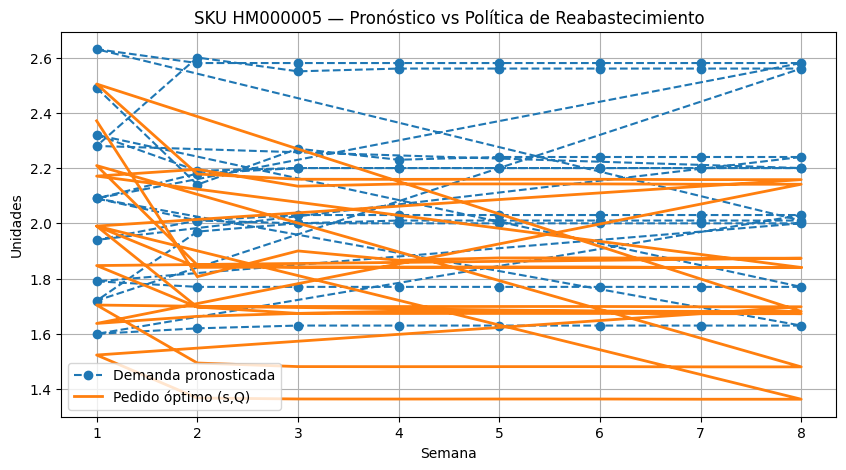

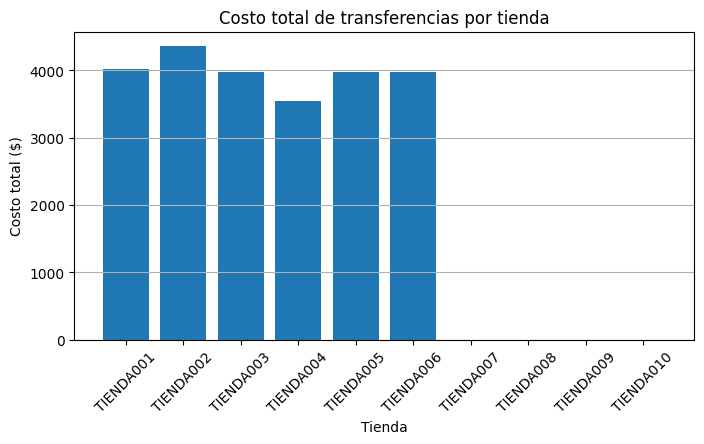

In [2]:
# ===============================================================
# 🧩 BLOQUE 2 — ANÁLISIS Y VISUALIZACIÓN PRESCRIPTIVA
# ===============================================================
import pandas as pd
import matplotlib.pyplot as plt

# Cargar consolidado
df = pd.read_parquet("consolidado_prescriptivo.parquet")

# --- 1️⃣ Resumen general ---
print("Columnas disponibles:", df.columns.tolist())
print("Registros totales:", len(df))

# Métricas agregadas por tienda (costo_transferencia_total ya está agregado)
resumen_tienda = (
    df.groupby("tienda")
    .agg(
        demanda_total=("prediccion_ARIMA", "sum"),
        pedido_total=("pedido", "sum"),
        stock_promedio=("stock", "mean"),
        costo_transferencia=("costo_transferencia_total", "first")  # usar 'first' para tomar el valor único
    )
    .reset_index()
)
print("\nResumen por tienda:")
print(resumen_tienda)

# --- 2️⃣ Top 10 SKU por demanda pronosticada ---
top_skus = (
    df.groupby("sku")["prediccion_ARIMA"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 SKU por demanda pronosticada:")
print(top_skus)

# --- 3️⃣ Visualización: SKU con mayor demanda pronosticada ---
sku_top = top_skus.index[0]
ejemplo = df[df["sku"] == sku_top]

plt.figure(figsize=(10,5))
plt.plot(
    ejemplo["semana"],
    ejemplo["prediccion_ARIMA"],
    label="Demanda pronosticada",
    linestyle="--",
    marker="o"
)
plt.plot(
    ejemplo["semana"],
    ejemplo["pedido"],
    label="Pedido óptimo (s,Q)",
    linewidth=2
)
plt.title(f"SKU {sku_top} — Pronóstico vs Política de Reabastecimiento")
plt.xlabel("Semana")
plt.ylabel("Unidades")
plt.legend()
plt.grid(True)
plt.show()

# --- 4️⃣ Visualización: Costo logístico por tienda ---
plt.figure(figsize=(8,4))
plt.bar(resumen_tienda["tienda"], resumen_tienda["costo_transferencia"])
plt.title("Costo total de transferencias por tienda")
plt.xlabel("Tienda")
plt.ylabel("Costo total ($)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


In [ ]:
import pandas as pd
s = pd.read_csv("resultados_multi_periodo.csv")
s.groupby(["sku","semana"])["pedido"].sum().unstack(fill_value=0).iloc[:5,:10]

KeyError: 'periodo'

In [ ]:
f = pd.read_csv("resultados_forecast.csv").rename(columns={"semana_a_futuro":"semana"})
dem_ag = f.groupby("semana")["prediccion_ARIMA"].sum()
pedido_ag = s.groupby("semana")["pedido"].sum()
pd.concat([dem_ag, pedido_ag.rename("pedido_total")], axis=1).head(12)

,prediccion_ARIMA,pedido_total
1,48444.92,48611.4586
2,48767.12,48767.1200
3,48737.75,48737.7500
4,48750.14,48750.1400
5,48747.01,48747.0100
6,48751.14,48751.1400
7,48747.48,48747.4800
8,48750.87,48750.8700
